# IBM Optimizations using Qiskit

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/ibm/ibmq_compile_qss.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/ibm/ibmq_compile_qss.ipynb)

Below is a brief tutorial on Superstaq optimizations for IBM Quantum superconducting qubit devices. For more information on IBM Quantum, visit their website [here](https://www.ibm.com/quantum).

## Imports and API Token

This example tutorial notebook uses `qiskit-superstaq`, our Superstaq client for Qiskit; you can try it out by running `pip install qiskit-superstaq[examples]`:

In [1]:
try:
    import qiskit_superstaq as qss
except ImportError:
    print("Installing qiskit-superstaq...")
    %pip install --quiet 'qiskit-superstaq[examples]'
    print("Installed qiskit-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import qiskit_superstaq as qss

import random

import numpy as np
import qiskit

To interface Superstaq via Qiskit, we must first instantiate a provider in `qiskit-superstaq` with `SuperstaqProvider()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `qss.SuperstaqProvider()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_qss.html#Set-up-access-to-Superstaq%E2%80%99s-API))

In [2]:
# Provide your Superstaq API key using the "api_key" argument
provider = qss.SuperstaqProvider()

## Single Circuit Compilation

Let us start by creating an example Qiskit circuit that we will then compile and optimize for the 156-qubit IBM Quantum `Kingston` processor.

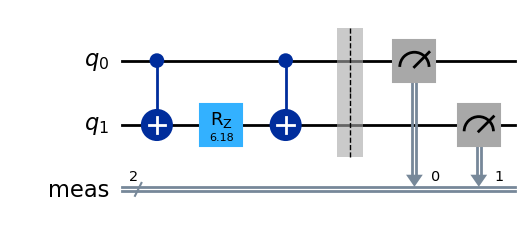

In [3]:
# Create a two-qubit qiskit circuit
rng = np.random.default_rng(random.getrandbits(128))
theta = rng.uniform(0, 4 * np.pi)
circuit = qiskit.QuantumCircuit(2)
circuit.cx(0, 1)
circuit.rz(theta, 1)
circuit.cx(0, 1)
circuit.measure_all()

# Draw circuit for visualization
circuit.draw(output="mpl")

We will now compile the above circuit to IBM's `Kingston` processor and visualize the differences by drawing the compiled circuit. 

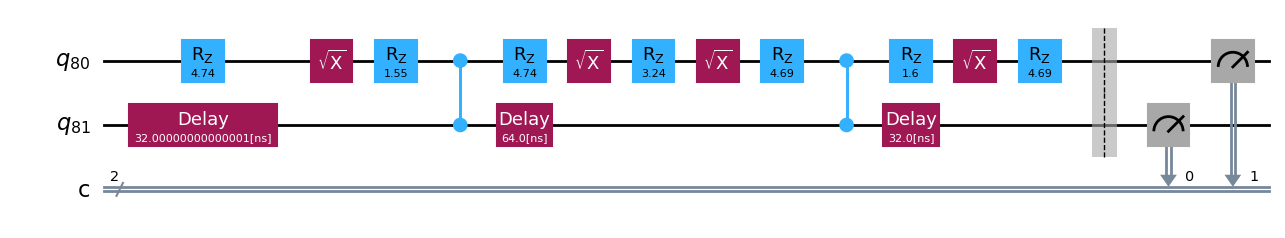

In [4]:
# Compile with ibmq compile
compiler_output = provider.ibmq_compile(circuit, target="ibmq_kingston_qpu")

# Call circuit from the compiler output to get the corresponding output circuit
output_circuit = compiler_output.circuit

# Visualize the compiled circuit
output_circuit.draw("mpl", idle_wires=False)

The resulting output is now a circuit compiled to `Kingston`'s native operations. With Superstaq compilation, you can also observe the gates and gate times for the compiled circuit using Qiskit’s timeline drawer (see [Qiskit Timeline Visualizations Documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.visualization.timeline_drawer)). 

Additionally, to ensure that the drawer has all the information on the instruction durations, we must also provide the `qiskit.transpiler.Target` of the corresponding backend the timeline is being generated for. It can be retrieved like so: 

In [5]:
backend_target = provider.get_backend("ibmq_kingston_qpu").target

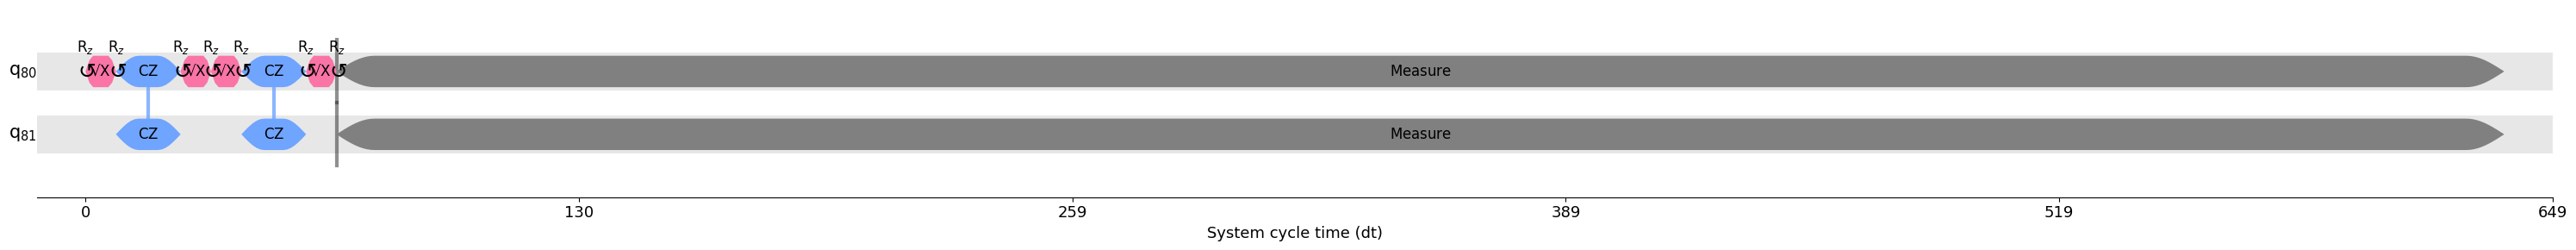

In [6]:
# The pulse gate circuit is obtained via the `pulse_gate_circuit` attribute
pulse_circuit = compiler_output.pulse_gate_circuit

# Estimate circuit duration for the timeline drawer
pulse_circuit.duration = pulse_circuit.estimate_duration(backend_target, unit="dt")

custom_style = {"formatter.general.fig_width": 30, "formatter.general.fig_unit_height": 1}
style = qiskit.visualization.timeline.IQXStandard(**custom_style)

qiskit.visualization.timeline_drawer(
    pulse_circuit, idle_wires=False, style=style, target=backend_target
)

## Multiple Circuits Compilation

All the functionalities we have seen so far can also be used on a multiple-circuit input as well. To illustrate this, let us create a different example two-qubit circuit: a Bell-state circuit.

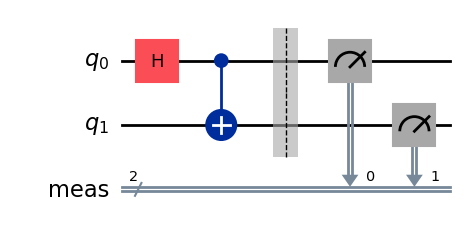

In [7]:
# Create second circuit
bell_circuit = qiskit.QuantumCircuit(2)
bell_circuit.h(0)
bell_circuit.cx(0, 1)
bell_circuit.measure_all()

# Draw second circuit for visualization
bell_circuit.draw("mpl")

By passing multiple circuits as a list to the `ibmq_compile` endpoint, we can compile all of them individually with a single call to the endpoint. This will return all the corresponding compiled circuits and pulse gate circuits back as a list, like so:  

In [8]:
# Create list of circuits
circuit_list = [circuit, bell_circuit]

# Compile list of circuits
compiler_output_list = provider.ibmq_compile(circuit_list, "ibmq_kingston_qpu")

# The list of compiled output circuits is stored in the `circuits` attribute instead of `circuit`. Likewise for
# pulse sequences.
output_circuits = compiler_output_list.circuits
pulse_gate_circuits = compiler_output_list.pulse_gate_circuits

Compiled circuit 1 



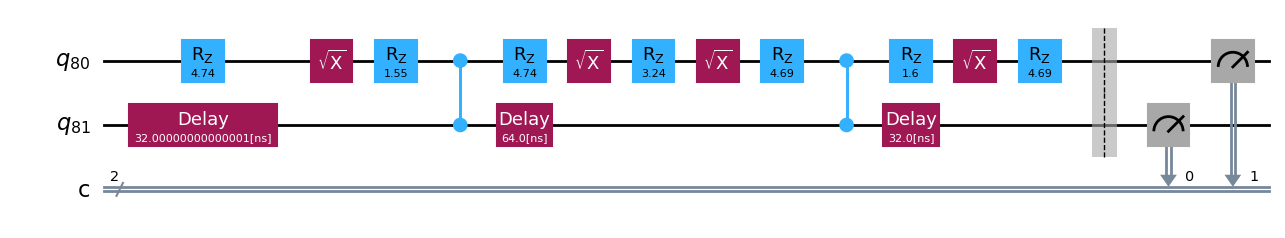

In [9]:
# Visualize the first compiled circuit
print("Compiled circuit 1 \n")
output_circuits[0].draw("mpl", idle_wires=False)

In [10]:
# Estimate circuit durations for the timeline drawer
pulse_circuits = []
for pg_qc in pulse_gate_circuits:
    pg_qc.duration = pg_qc.estimate_duration(backend_target, unit="dt")
    pulse_circuits.append(pg_qc)

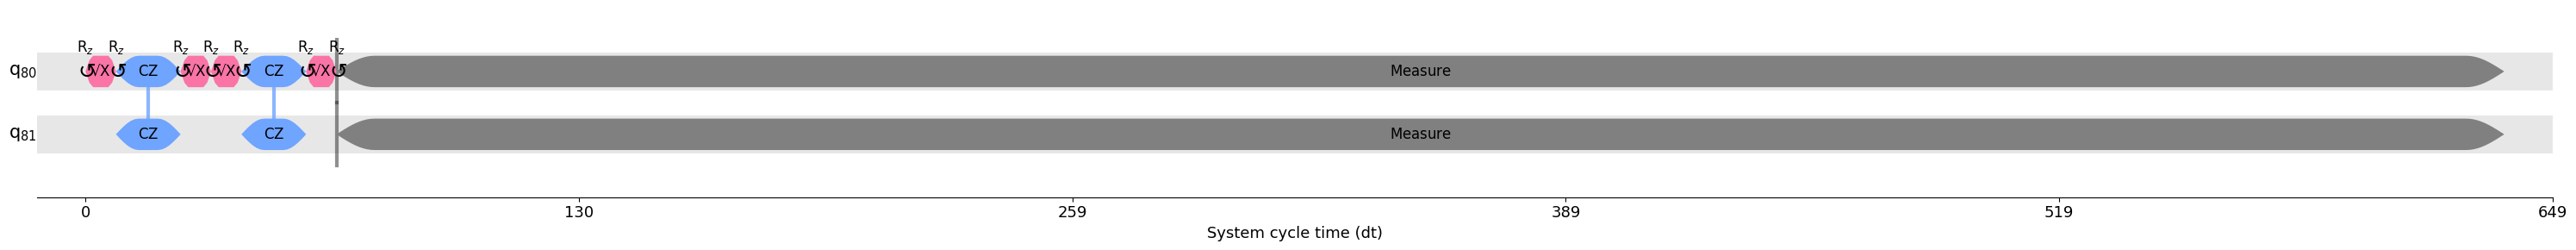

In [11]:
# Visualize the pulse gate circuit for the first compiled circuit
qiskit.visualization.timeline_drawer(
    pulse_circuits[0], idle_wires=False, style=style, target=backend_target
)

Compiled circuit 2 



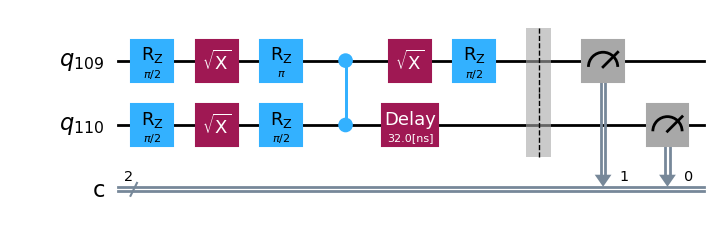

In [12]:
# Visualize the second compiled circuit
print("Compiled circuit 2 \n")
output_circuits[1].draw("mpl", idle_wires=False)

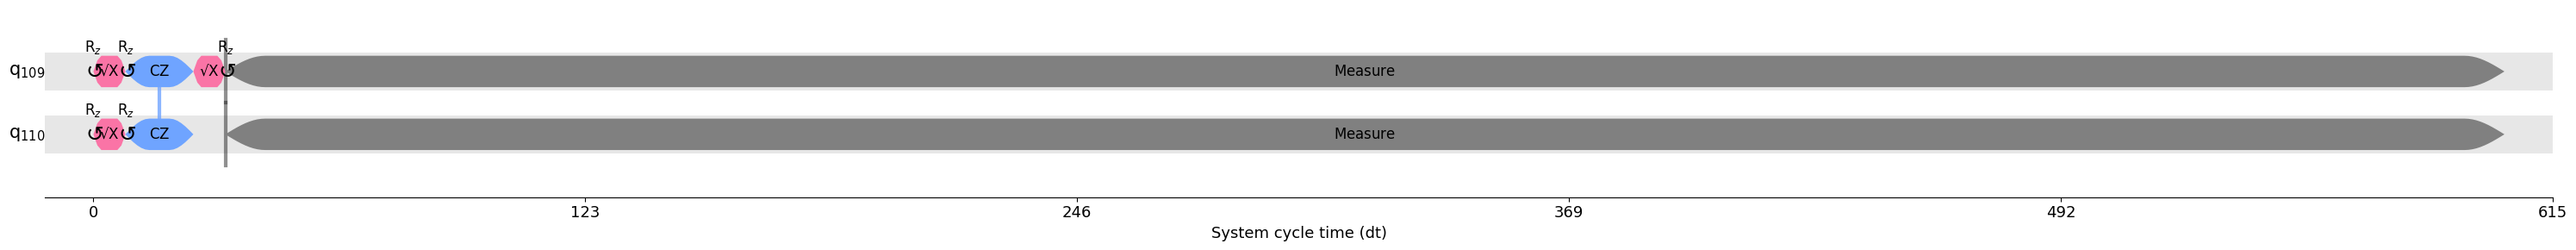

In [13]:
# Visualize the pulse gate circuit for the first compiled circuit
qiskit.visualization.timeline_drawer(
    pulse_circuits[1], idle_wires=False, style=style, target=backend_target
)

## Using the Superstaq Simulator

Lastly, we will show (a) how to execute a circuit on a backend and (b) how to simulate circuit execution. Simulation is available to free trial users, and can be done by passing the `"dry-run"` method parameter when calling `run()` on the Superstaq provider.

In [14]:
# Get IBM Quantum backend from provider
backend = provider.get_backend("ibmq_kingston_qpu")
job = backend.run(
    bell_circuit,
    shots=1000,
    method="dry-run",  # Specify "dry-run" as the method to run Superstaq simulation
)

# Get the counts from the measurement
print(job.result().get_counts())

{'00': 482, '11': 518}


### Addendum: Compiling via Superstaq backend
You can also compile circuits via the `compile` method of the backend directly. This is identical to calling `ibmq_compile` on the provider, but more closely matches Qiskit syntax.

In [15]:
compiler_output = backend.compile(bell_circuit)
output_circuit = compiler_output.circuit

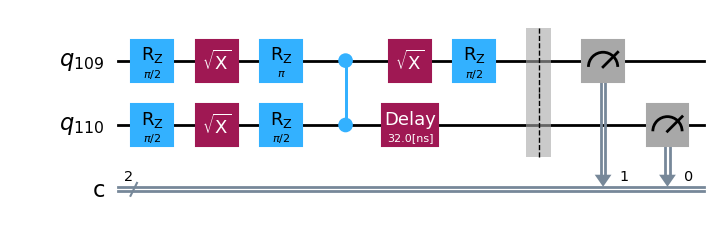

In [16]:
# Visualize the compiled circuit
output_circuit.draw("mpl", idle_wires=False)

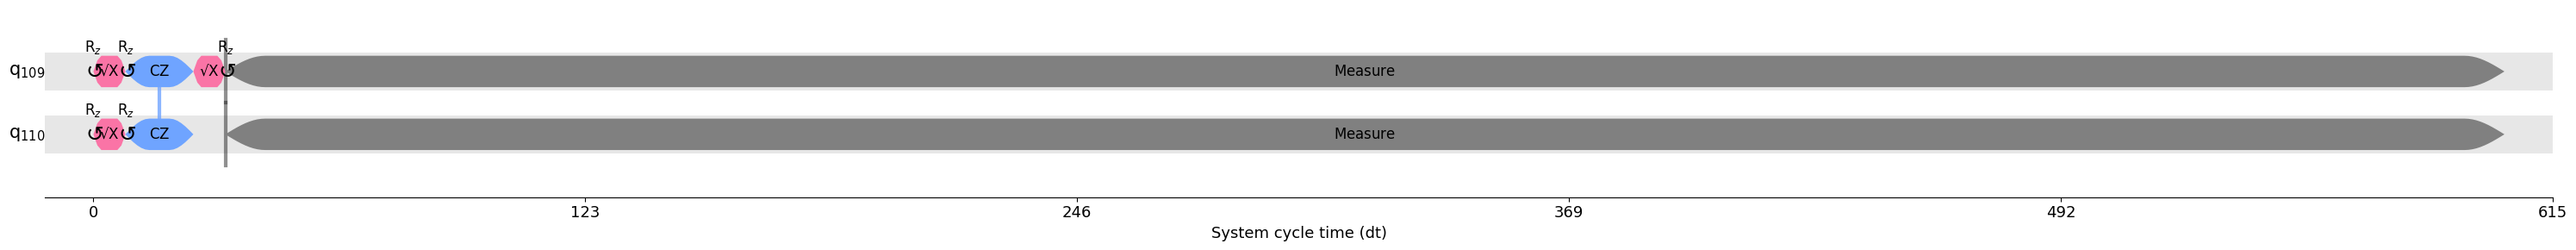

In [17]:
pulse_circuit = compiler_output.pulse_gate_circuit

# Estimate circuit duration for the timeline drawer
pulse_circuit.duration = pulse_circuit.estimate_duration(backend_target, unit="dt")

# Visualize the pulse gate circuit
qiskit.visualization.timeline_drawer(
    pulse_circuit, idle_wires=False, style=style, target=backend.target
)